# Capstone 2 Pre-processing and Training Data Development

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   **Pre-processing and Training Data Development**
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   Modeling 
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
df2.head()

,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Daily
Date,,,,,,,,,,,,,,
2016-01-04,16.39,36.27,78.68,51.44,57.70,148.93,74.55,50.34,56.02,79.35,58.34,31.68,0.00,739.69
2016-01-05,22.45,27.75,7.25,30.64,100.67,149.72,43.14,68.53,93.65,75.90,27.45,31.70,0.00,678.85
2016-01-06,33.59,41.48,111.56,92.00,94.83,94.27,45.26,70.35,57.22,52.53,46.87,49.12,0.00,789.08
2016-01-07,8.40,23.30,54.49,42.28,116.13,101.65,52.04,47.96,128.00,77.01,91.02,75.42,0.00,817.70
2016-01-08,27.25,86.00,48.34,65.21,186.20,158.67,93.76,117.30,143.23,105.70,182.96,89.71,64.12,1368.45


In [3]:
dfts = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\dfts.csv', index_col='Date')
dfts.index = pd.to_datetime(dfts.index)
len(dfts)

9464

# Rolling Statistics (visual stationary test)

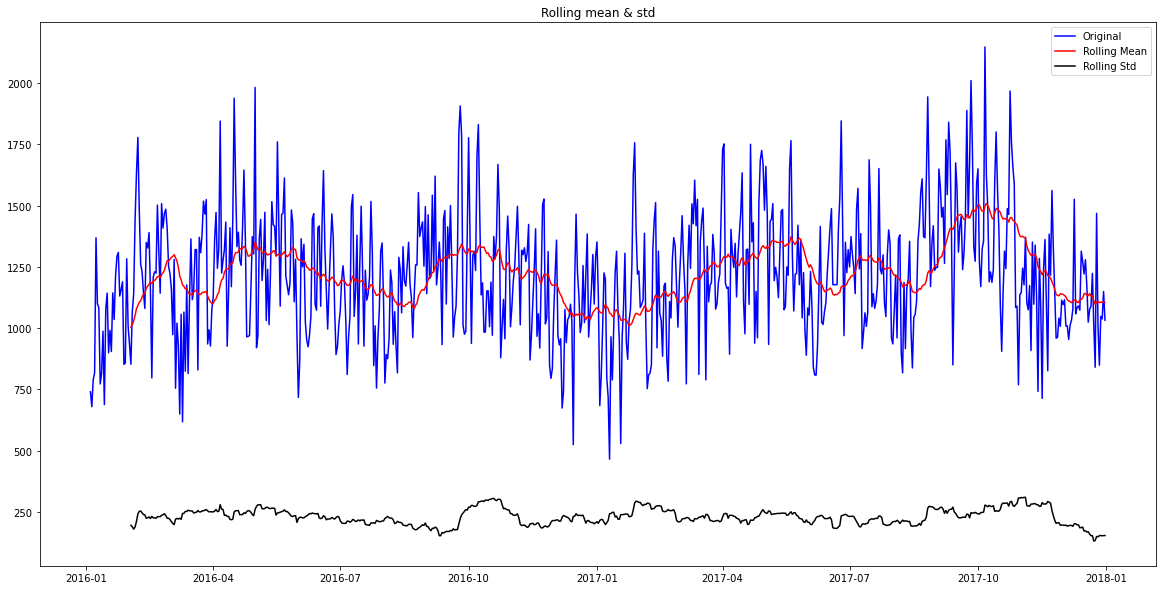

In [4]:
# let's do a weekly sales plots for 2016
# calculate the rolling mean and std on monthly basis
rolmean2 = df2.Daily.rolling(window=30).mean()
rolstd2 = df2.Daily.rolling(window=30).std()

plt.figure(figsize=(20,10))
original = plt.plot(df2.Daily, color = 'blue', label='Original')
mean = plt.plot(rolmean2, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd2, color = 'black', label='Rolling Std')
plt.legend(loc=1)
plt.title('Rolling mean & std')
plt.show()

Both the rolling std and rolling mean doesn't seem to have a trend, so the data appears to be stationary.

# ADCF Test for stationary

In [5]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(df2.Daily, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '# of lags used', '# of observation used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistics           -4.275553
p-value                    0.000490
# of lags used            13.000000
# of observation used    714.000000
Critical Value (1%)       -3.439542
Critical Value (5%)       -2.865596
Critical Value (10%)      -2.568930
dtype: float64


With p-value of 0.0005 from adfuller's test, we'll reject the null hypothesis of the data being non-stationary.
**The data is stationary, and since df2 is from 2016-1-14 to end of 2017, the whole timerseries are stationary; this includes the subset of the data, so we will not be testing for 2016 and 2017's datasets.**

In [6]:
# test for hourly dataset
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dfts.sales, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '# of lags used', '# of observation used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistics         -1.094471e+01
p-value                  9.108532e-20
# of lags used           3.800000e+01
# of observation used    9.425000e+03
Critical Value (1%)     -3.431044e+00
Critical Value (5%)     -2.861847e+00
Critical Value (10%)    -2.566933e+00
dtype: float64


**the p-value is close to 0, we'll reject the null hypothesis. The hourly timeseries dataset is stionary as well!**

# Seasonal Decomposition
Using seasonal_decompose to find the trend, seasonality, and residuals.

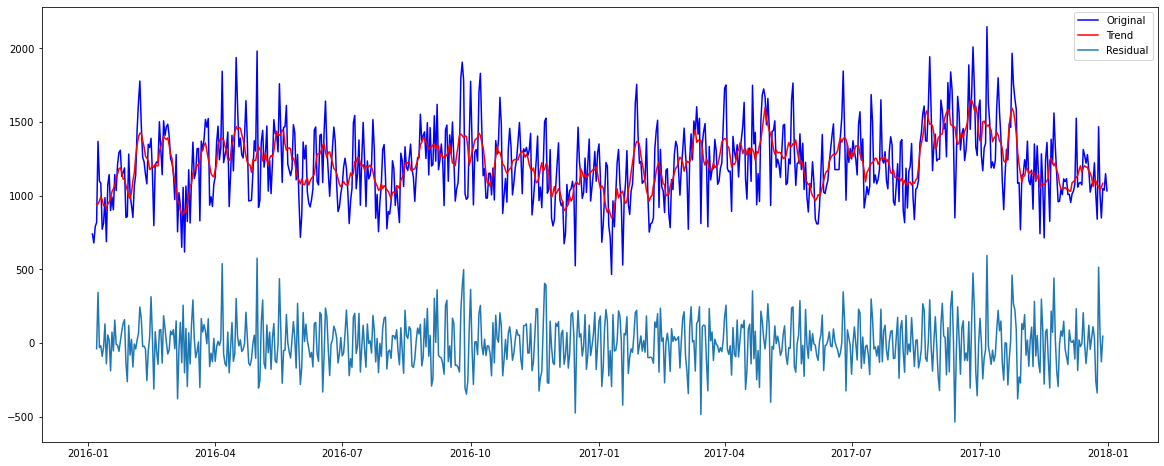

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2.Daily)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,8))
plt.plot(df2.Daily, label='Original', color='blue')
plt.plot(trend, label='Trend', color='red')
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.show()

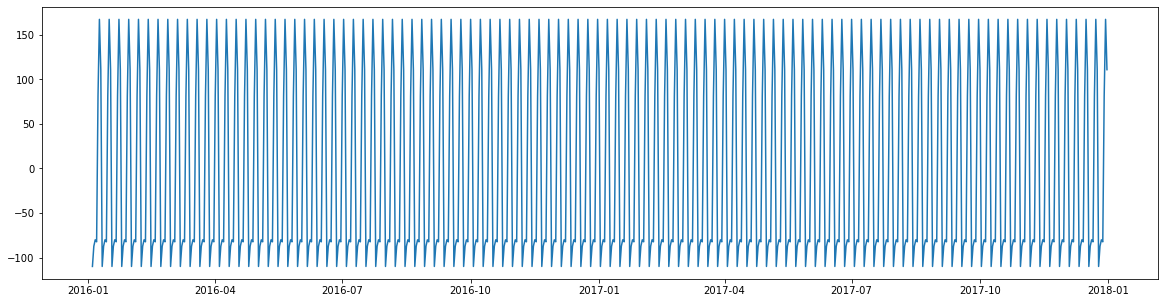

In [8]:
# seaonality
plt.figure(figsize=(20,5))
plt.plot(seasonal[:len(seasonal)/2], label='Seasonality')
plt.show()

In [9]:
# from the visual, the residual doesn't seem to have a trend, but we will do the stationary test for it to double check
dfres = residual
dfres = pd.Series(dfres)
dfres = dfres.dropna()

print('Results of Dickey-Fuller Test:')
dftest = adfuller(dfres, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '# of lags used', '# of observation used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistics         -1.308295e+01
p-value                  1.854632e-24
# of lags used           1.800000e+01
# of observation used    7.030000e+02
Critical Value (1%)     -3.439686e+00
Critical Value (5%)     -2.865660e+00
Critical Value (10%)    -2.568964e+00
dtype: float64


The visual doesn't seem to have trend, adfuller's resulting p-value is almost zero, null hypothesis rejected. Residuals are also stationary.

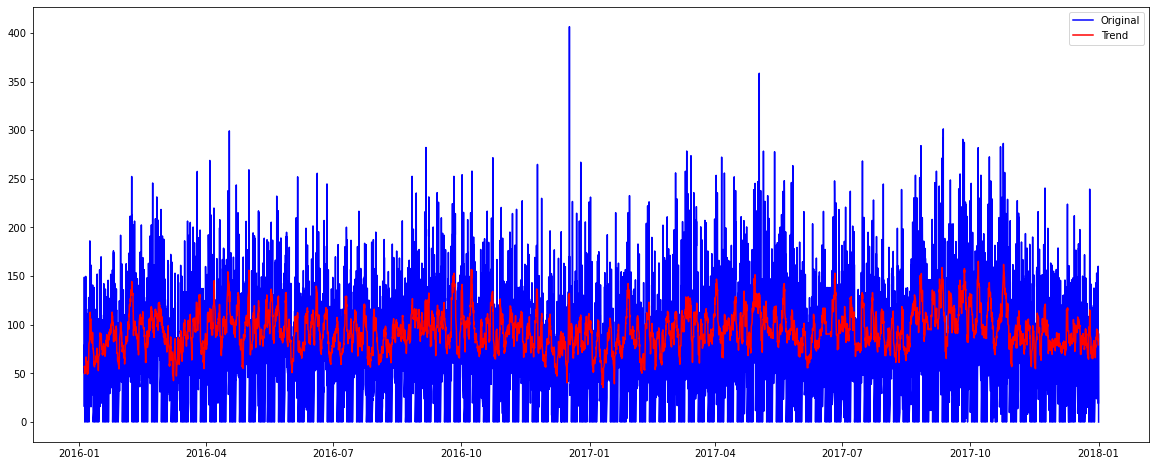

In [10]:
# do the same for hourly dataset, freq=13 since each day the store open for 12-13 hours
# recall the dataset had 13th hour = $0 for days that only open 12 hours
decomposition = seasonal_decompose(dfts, freq=13)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,8))
plt.plot(dfts, label='Original', color='blue')
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')
plt.show()

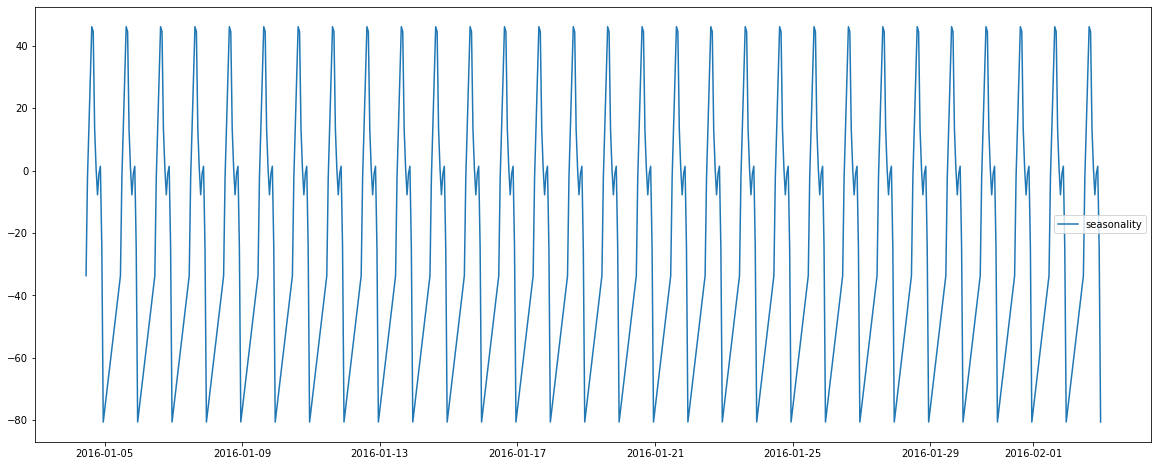

In [11]:
# hourly sales seasonality, the visual was full of color (too many points, so I took the first 390 points, which is 1 month)
plt.figure(figsize=(20,8))
plt.plot(seasonal[:390], label='seasonality')
plt.legend(loc='best')
plt.show()

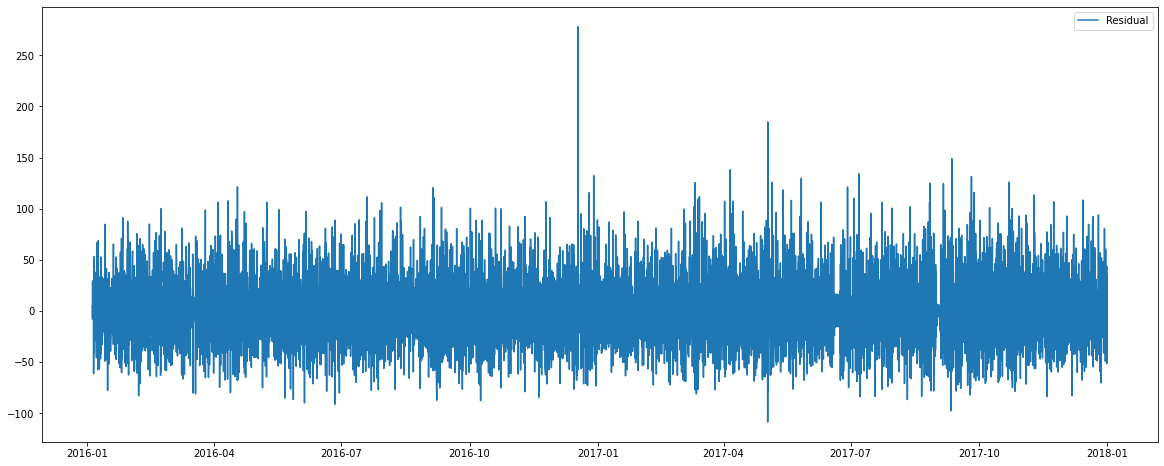

In [12]:
# hourly sales residual
plt.figure(figsize=(20,8))
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.show()

In [18]:
# we will now do the stationary test for the hourly residuals to see if it's stationary by using adfuller
dfres = residual
dfres = dfres.dropna()

print('Results of Dickey-Fuller Test:')
dftest = adfuller(dfres.sales, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '# of lags used', '# of observation used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistics           -29.951688
p-value                     0.000000
# of lags used             38.000000
# of observation used    9413.000000
Critical Value (1%)        -3.431045
Critical Value (5%)        -2.861847
Critical Value (10%)       -2.566933
dtype: float64


The houly residual's visual doesn't seem to have trend, its adfuller resulting p-value is almost zero, null hypothesis rejected. Hourly residuals are also stationary.

**Now that we have confirmed all the datasets to be stationary timeseries dataset, we are ready for timeseries modeling!!!**